# Segementation Comparision

## Get Data and Labels

In [1]:
import os
from joblib import Parallel, delayed
import numpy as np
import nrrd
import matplotlib.pyplot as plt


In [2]:
results_dir = '../../results/obiroi_brain_20231205_1133/syn'
# get all the files in the results directory
files = os.listdir(results_dir)
# keep only warp files
files = [f for f in files if f.endswith('Warp.nii.gz')]
# remove the inverse warp files
files = [f for f in files if not f.endswith('InverseWarp.nii.gz')]
print('Found {} files'.format(len(files)))

Found 40 files


In [3]:
processed_data_dir = 'whole_brain/processed_data'
# check if the processed data directory exists
if not os.path.exists(processed_data_dir):
    print('Directory {} does not exist'.format(processed_data_dir))
    exit()
else:
    print('Found directory {}'.format(processed_data_dir))

In [4]:
# get the jacobian of all the warp files (parallel using joblib)

n_cpus = os.cpu_count()
print('Using {} cpus'.format(n_cpus))

def get_jacobian(f):
    file_to_process = os.path.join(results_dir, f)
    processed_file = os.path.join(processed_data_dir, os.path.basename(f)[:-7] + '_logjacobian.nrrd')
    
    # if the file already exists, skip it
    if os.path.exists(processed_file):
        return processed_file
    jacobian_command = 'CreateJacobianDeterminantImage 3 {} {} 1 1'.format(file_to_process, processed_file)
    os.system(jacobian_command)
    return processed_file

jacobian_files = Parallel(n_jobs=n_cpus)(delayed(get_jacobian)(f) for f in files)

print('Found {} jacobian files'.format(len(jacobian_files)))
for f in jacobian_files:
    print(f)

In [6]:
# read the jacobian files using pynrrd
jacobians = []
for f in jacobian_files:
    print('Read file {}'.format(f))
    j, _ = nrrd.read(f)
    jacobians.append(j)

Read file whole_brain/processed_data/complete_synA647_DF_C07_mirror_resampled_0.8x0.8x0Warp_logjacobian.nrrd
Read file whole_brain/processed_data/complete_synA647_LL_L4_200724_resampled_0.8x0.8x0Warp_logjacobian.nrrd
Read file whole_brain/processed_data/complete_synA647_LL_201123_C22_mirror_resampled_0.8x0.8x0Warp_logjacobian.nrrd
Read file whole_brain/processed_data/complete_synA647_DF_B05_C_mirror_resampled_0.8x0.8x0Warp_logjacobian.nrrd
Read file whole_brain/processed_data/complete_synA647_DF_C01_resampled_0.8x0.8x0Warp_logjacobian.nrrd
Read file whole_brain/processed_data/complete_synA647_LL_201213_211_mirror_resampled_0.8x0.8x0Warp_logjacobian.nrrd
Read file whole_brain/processed_data/complete_synA647_LL_15_220217_resampled_0.8x0.8x0Warp_logjacobian.nrrd
Read file whole_brain/processed_data/complete_synA647_DF_B03_D_mirror_resampled_0.8x0.8x0Warp_logjacobian.nrrd
Read file whole_brain/processed_data/complete_synA647_DF_C04-fixed_resampled_0.8x0.8x0Warp_logjacobian.nrrd
Read file w

In [7]:
# get the standard deviation of the jacobians

mean_jacobian = np.mean(jacobians, axis=0)
std_jacobian = np.std(jacobians, axis=0)
# get the header of the first file
header = nrrd.read_header(jacobian_files[0])
# save the mean jacobian as a nrrd file
nrrd.write('whole_brain/mean_logjacobian.nrrd', mean_jacobian, header)
# save the sd jacobian as a nrrd file
nrrd.write('whole_brain/sd_logjacobian.nrrd', std_jacobian, header)
print('Saved mean and sd jacobian files')

In [8]:
jacobian_values = np.array(jacobians).flatten()

In [9]:
mean_val = np.mean(jacobian_values)
std_val = np.std(jacobian_values)
CI_95 = np.percentile(jacobian_values, [2.5, 97.5])

In [10]:
print('Mean log jacobian: {:.4f}'.format(mean_val))
print('SD log jacobian: {:.4f}'.format(std_val))
print('95% CI: [{:.4f}, {:.4f}]'.format(CI_95[0], CI_95[1]))

Mean log jacobian: -0.0077
SD log jacobian: 0.1228
95% CI: [-0.2871, 0.2552]


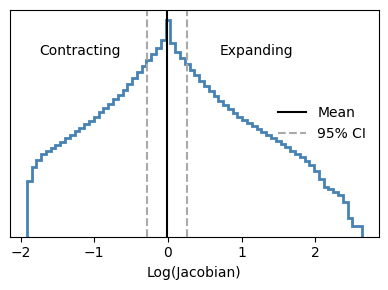

: 

In [11]:
# get a histogram of the jacobians (dont show the plot)

# turn off interactive mode
plt.ioff()

plt.figure(figsize=(4, 3))
plt.hist(jacobian_values, bins=70, color='steelblue', histtype='step', linewidth=2)
# add a vertical line at the mean with text
plt.axvline(x=mean_val, color='k', linestyle='-', label='Mean')
# plt.text(mean_val - 0.2, 1e5, '{:.2f}'.format(mean_val), color='k', rotation=90, verticalalignment='center')
# add a vertical line at the CI 95% with text
plt.axvline(x=CI_95[0], color='darkgrey', linestyle='--')
# plt.text(CI_95[0] - 0.2, 1e5, '{:.2f}'.format(CI_95[0]), color='darkgrey', rotation=90, verticalalignment='center')
plt.axvline(x=CI_95[1], color='darkgrey', linestyle='--', label='95% CI')
# plt.text(CI_95[1] - 0.2, 1e5, '{:.2f}'.format(CI_95[1]), color='darkgrey', rotation=90, verticalalignment='center')
# add text at -1 and 1 (contracting and expanding)
plt.text(-1.2, 1e8, 'Contracting', color='k', verticalalignment='center', horizontalalignment='center')
plt.text(1.2, 1e8, 'Expanding', color='k', verticalalignment='center', horizontalalignment='center')
plt.xlabel('Log(Jacobian)')
plt.yscale('log')
plt.yticks([])
plt.legend(loc='center right', frameon=False)
plt.tight_layout()
plt.savefig('whole_brain/jacobian_histogram.png', dpi=300)
plt.close()